# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые приобрели у оператора связи тот или иной пакет услуг. Мы хотим построить модель для задачи классификации, которая выберет подходящий тариф.

Задача:

Построить модель с максимально большим значением *accuracy*. Проект является обучающим, поэтому установим порог точности 0.75.

## Знакомство с данными

In [1]:
# игнорирование предупреждений о несоответствии версий
import warnings
warnings.filterwarnings('ignore')

# импортируем механизм масштабирования
from sklearn.preprocessing import StandardScaler

# импортируем библиотеку для работы с таблицами
import pandas as pd

# импортируем модели для обучения
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# импортируем инструменты для работы с моделями
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Библиотеки для работы с графиками
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('~/Telecom/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Данные в таблице представлены в числовом формате и подходят для построения модели. Разброс данных достаточно велик, поэтому рекомендуется произвести масштабирование.

## Разделим данные на выборки

In [6]:
# разобьем датасет на выборки в пропорции 3:1:1
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

# выделим обучающую выборку в размере 60% датасета
features_train, features_val_test, target_train, target_val_test = train_test_split(features, target, test_size=0.4,
                                                                             random_state=12345)
# Оставшиеся данные разделим на валидационную и тестовую выборку
features_valid, features_test, target_valid, target_test = train_test_split(features_val_test, target_val_test,
                                                                              test_size=0.5, random_state=12345)

<AxesSubplot:>

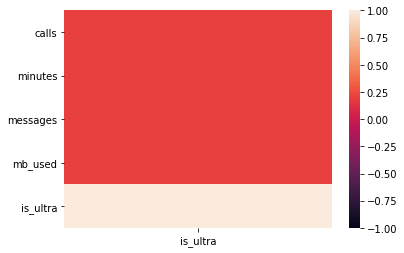

In [7]:
# проверим данные на корреляцию
sns.heatmap(data.corr()[['is_ultra']], vmax=1, vmin=-1)

## Исследование моделей

Проведем исследование эффективности моделей при выполнении поставленной задачи. Для реализации возмем следующие модели:
- Дерево решений
- Случайный лес
- Логистическая регрессия

Для хранения и визуализации результатов создадим отдельный датафрейм для каждого исследования.

In [8]:
# Обучим модель для масштабирования признаков
scaler = StandardScaler()
scaler = scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

### Дерево решений

In [9]:
# Датафрейм в размере равном гиперпараметрам depth и min_samples_split
tree_df = pd.DataFrame(index=range(1, 11), columns=range(10, 26))

In [10]:
%%time
# С помощью цикла определим лучшие значения гиперпараметров модели
best_depth = 0
best_samples_split = 0
best_accuracy = 0
best_tree = None
for depth in range(1, 11):
    for samples_split in range(10, 26):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=samples_split)
        model_tree.fit(features_train, target_train)
        prediction_valid = model_tree.predict(features_valid)
        accuracy_tree = accuracy_score(target_valid, prediction_valid)
        tree_df.loc[depth, samples_split] = accuracy_tree
        if accuracy_tree > best_accuracy:
            best_accuracy = accuracy_tree
            best_samples_split = samples_split
            best_depth = depth
            best_tree = model_tree
print(f'''Лучшее соотношение гиперпараметров:
      depth - {best_depth}
      min_samples_split - {best_samples_split}
      accuracy равен: {best_accuracy}''')

Лучшее соотношение гиперпараметров:
      depth - 6
      min_samples_split - 17
      accuracy равен: 0.7869362363919129
CPU times: user 738 ms, sys: 107 µs, total: 738 ms
Wall time: 741 ms


Проиллюстрируем результаты работы модели

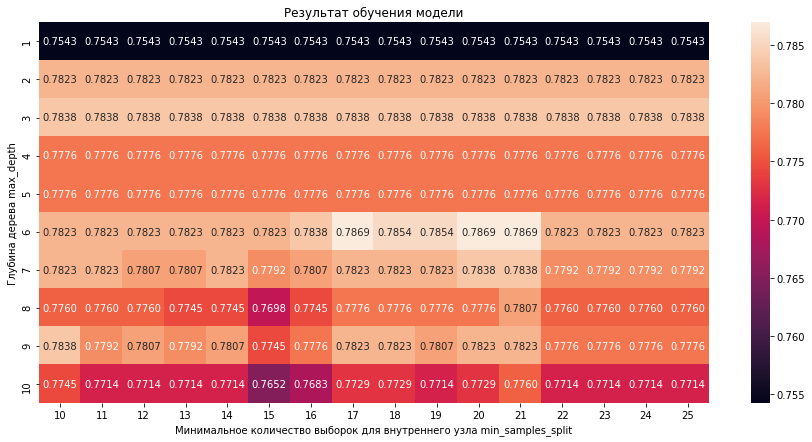

In [11]:
# Перевод данных в численный формат
tree_df = tree_df.astype('float')
# Строим heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(tree_df, annot = True, fmt='.4f')
plt.xlabel('Минимальное количество выборок для внутреннего узла min_samples_split')
plt.ylabel('Глубина дерева max_depth')
plt.title('Результат обучения модели')
plt.show()

Наилучший результат достигается при значениях:
- depth - 6, min_samples_split - 17
- depth - 6, min_samples_split - 20
- depth - 6, min_samples_split - 21

### Визуализируем дерево решений

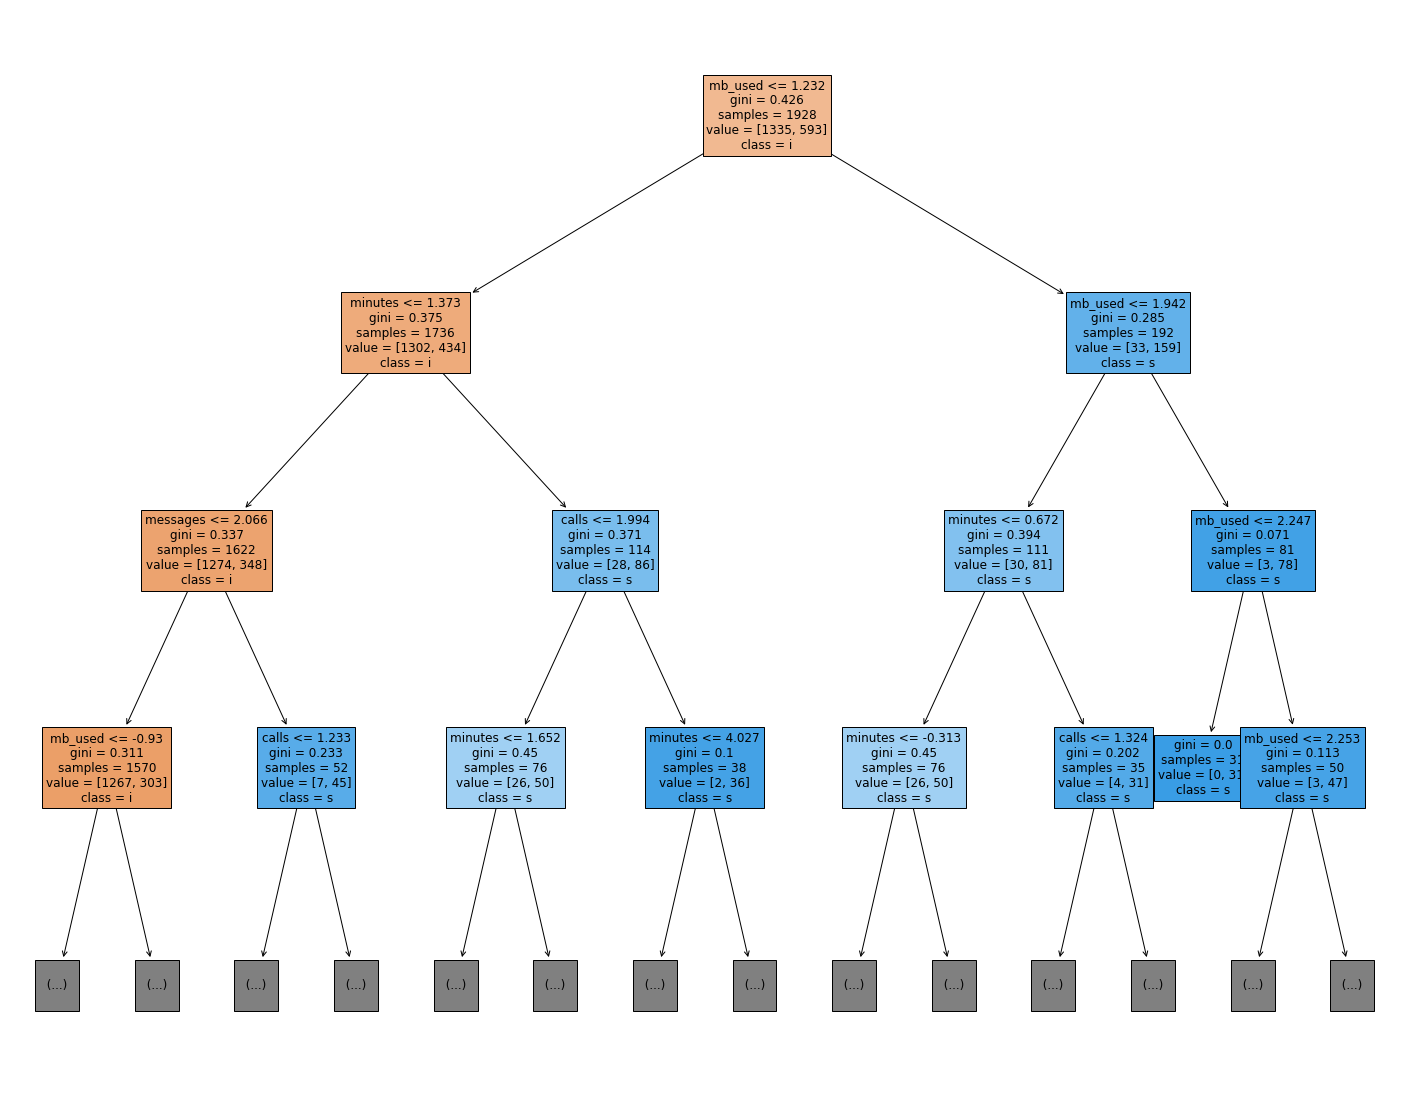

In [12]:
from sklearn.tree import plot_tree

plt.figure(figsize=(25,20))
plot_tree(model_tree, 
                   feature_names=features.columns,  
                   class_names='is_ultra',
                   filled=True, max_depth=3, fontsize=12)
plt.show()

### Случайный лес

In [13]:
# Датафрейм в размере равном гиперпараметрам depth и n_estimators
forest_df = pd.DataFrame(index=range(1, 11), columns=range(100, 501, 20))

In [15]:
%%time
# С помощью цикла определим лучшие значения гиперпараметров модели
best_depth_f = 0
best_est_f = 0
best_accuracy_f = 0
best_forest = None
for depth in range(1, 11):
    for est in range(100, 501, 20):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model_forest.fit(features_train, target_train)
        prediction_valid_f = model_forest.predict(features_valid)
        accuracy_forest = accuracy_score(target_valid, prediction_valid_f)
        forest_df.loc[depth, est] = accuracy_forest
        if accuracy_forest > best_accuracy_f:
            best_accuracy_f = accuracy_forest
            best_est_f = est
            best_depth_f = depth
            best_forest = model_forest
print(f'''Лучшее соотношение гиперпараметров:
      depth - {best_depth_f}
      n_estimators - {best_est_f}
      accuracy равен: {best_accuracy_f}''')

Лучшее соотношение гиперпараметров:
      depth - 7
      n_estimators - 320
      accuracy равен: 0.8055987558320373
CPU times: user 2min 38s, sys: 1.13 s, total: 2min 39s
Wall time: 2min 39s


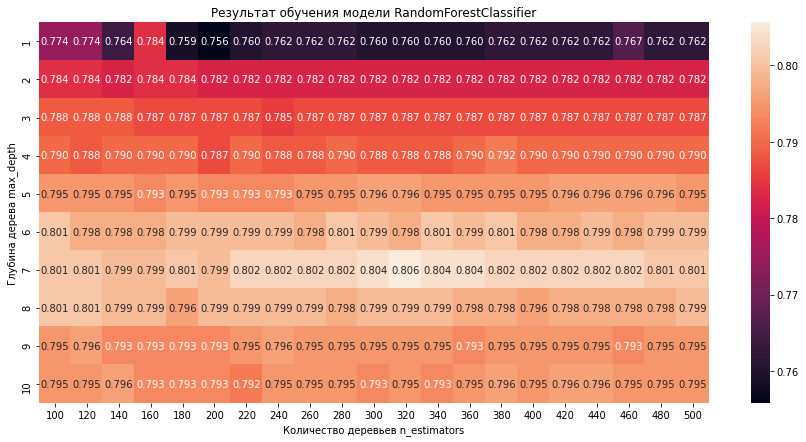

In [16]:
# Перевод данных в численный формат
forest_df = forest_df.astype('float')
# Строим heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(forest_df, annot = True, fmt='.3f')
plt.xlabel('Количество деревьев n_estimators')
plt.ylabel('Глубина дерева max_depth')
plt.title('Результат обучения модели RandomForestClassifier')
plt.show()

### Логистическая регрессия

In [17]:
logreg_df = pd.DataFrame(index=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], columns=range(500, 1501, 100))

In [18]:
%%time
# С помощью цикла определим лучшие значения гиперпараметров модели solver и max_iter
best_solver = 0
best_max_iter = 0
best_accuracy_logreg = 0
best_logreg = None
for solver_lr in logreg_df.index:
    for max_iter_lr in range(500, 1501, 100):
        model_logreg = LogisticRegression(solver=solver_lr, max_iter=max_iter_lr)
        model_logreg.fit(features_train, target_train)
        prediction_valid_logreg = model_logreg.predict(features_valid)
        accuracy_logreg = accuracy_score(target_valid, prediction_valid_logreg)
        logreg_df.loc[solver_lr, max_iter_lr] = accuracy_logreg
        if accuracy_logreg > best_accuracy_logreg:
            best_accuracy_logreg = accuracy_logreg
            best_max_iter = max_iter_lr
            best_solver = solver_lr
            best_logreg = model_logreg
print(f'''Лучшее соотношение гиперпараметров:
      solver - {best_solver}
      max_iter - {best_max_iter}
      accuracy равен: {best_accuracy_logreg}''')

Лучшее соотношение гиперпараметров:
      solver - newton-cg
      max_iter - 500
      accuracy равен: 0.7558320373250389
CPU times: user 361 ms, sys: 0 ns, total: 361 ms
Wall time: 368 ms


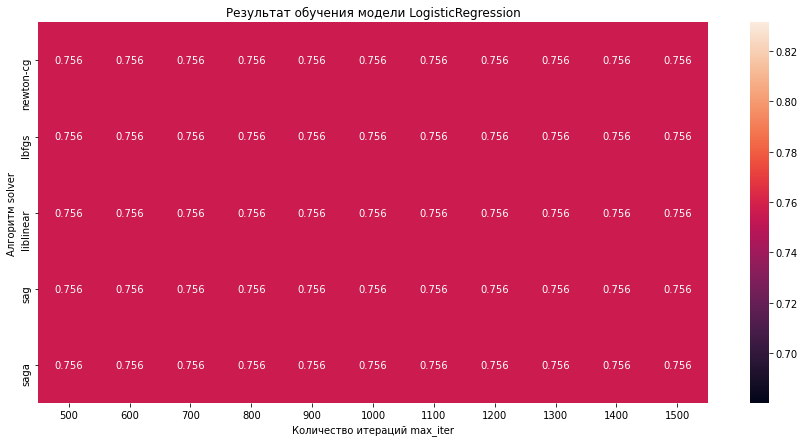

In [19]:
# Перевод данных в численный формат
logreg_df = logreg_df.astype('float')
# Строим heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(logreg_df, annot = True, fmt='.3f')
plt.xlabel('Количество итераций max_iter')
plt.ylabel('Алгоритм solver')
plt.title('Результат обучения модели LogisticRegression')
plt.show()

По результатом исследования, наибольшая эффективность достигнута моделью "Случайный лес". При работе с тестовыми данными будем использовать эту модель.

## Проверка модели на тестовой выборке

In [20]:
# Проверим модель на тестовых данных
prediction_test = model_forest.predict(features_test)
accuracy_test = accuracy_score(target_test, prediction_test)

In [21]:
accuracy_test

0.7993779160186625

Получен удовлетворительный результат accuracy превышает значение 0.75

In [22]:
big_train_feat = pd.concat([pd.DataFrame(features_train), pd.DataFrame(features_valid)])
big_train_target = pd.concat([pd.DataFrame(target_train), pd.DataFrame(target_valid)])

In [23]:
model_forest_2 = RandomForestClassifier(random_state=12345, max_depth=7, n_estimators=320)
model_forest_2.fit(big_train_feat, big_train_target)
prediction_valid_f_2 = model_forest_2.predict(features_test)
accuracy_2 = accuracy_score(target_test, prediction_valid_f_2)
        
print(f'''При max_depth = 7
      n_estimators = 320
      accuracy равен: {accuracy_2}''')

При max_depth = 7
      n_estimators = 320
      accuracy равен: 0.7978227060653188


### Время взглянуть на целевую метрику

In [29]:
from sklearn.metrics import classification_report
#from sklearn.metrics import precision_recall_curve, classification_report

report = classification_report(target_test, prediction_valid_f_2, target_names=['Smart', 'Ultra'])
print(report)

              precision    recall  f1-score   support

       Smart       0.80      0.93      0.86       440
       Ultra       0.77      0.51      0.61       203

    accuracy                           0.80       643
   macro avg       0.79      0.72      0.74       643
weighted avg       0.79      0.80      0.78       643



### Проверим значимость признаков

In [30]:
# Функция визуализации значимости признаков
def show_coef(names, coef, positive=False):
    if positive:
        sns.barplot(y=names,x=abs(coef), orient='h')
    else:
        sns.barplot(y=names,x=coef, orient='h')
    plt.tight_layout
    plt.xlabel('Значимость')
    plt.ylabel('Признак')
    plt.title('Значимость признаков в построенной модели')
    plt.show()

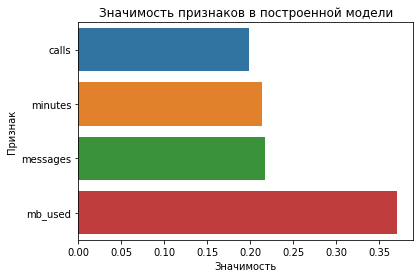

In [25]:
# Определим значимость признаков обученной модели
show_coef(features.columns.to_list(), model_forest.feature_importances_)

mb_used это самый влиятельный признак.

## Проверка модели на адекватность

In [31]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(big_train_feat, big_train_target)
DummyClassifier(random_state=12345, strategy='most_frequent')
clf.score(features_test, target_test)


0.6842923794712286

Я так понял, она просто сделала это

In [43]:
target_test[target_test == 0].count() / target_test.shape[0]

0.6842923794712286

Модель эффективнее константной модели.

## Вывод
В ходе работы были построены и исследованы три модели, выполняющих задачи классификации для определения тарифа. Предварительно было произведено масштабирование признаков для повышения достоверности исследования. В результате, моделями были продемонстрированы следующие результаты: 

- Дерево решений
      depth - 6
      min_samples_split - 17
      accuracy равен: 0.7869362363919129
- Случайный лес
      depth - 7
      n_estimators - 320
      accuracy равен: 0.8055987558320373
- Логистическая регрессия
      solver - newton-cg
      max_iter - 500
      accuracy равен: 0.7558320373250389

Показатель random_state для всех моделей установлен одинаковый, равный 12345.

Для работы с тестовой выборкой была выбрана модель "Случайный лес" как наиболее точная в прогнозах.
После обработки данных модель показала удовлетворительный результат accuracy = 0.7993, что соответствует порору 0.75. 